In [1]:
import sys
sys.path.append('..')

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

from models.basic_axial.basic_axialnet import BasicAxial
from models.basic_pga.basic_pga_net import BasicAxialPGA, OnlyPGA, BigOnlyPGA
from datasets.ice import Ice, IceWithProposals
from metrics.segmentation import _fast_hist, per_class_pixel_accuracy, jaccard_index
from metrics.utils import display_metric_list

import matplotlib.pyplot as plt

import os

In [2]:
data_dir = '../data'
img_scale = .35
img_crop = 220

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# test_set = Ice(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
#                   os.path.join(data_dir, 'txt_files'), 'test', img_scale, img_crop)
# test_loader = DataLoader(test_set, batch_size=1)
test_set = IceWithProposals(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
                  os.path.join(data_dir, 'txt_files'), os.path.join(data_dir, 'proposals/binary_250_16'),
                               'test', img_scale, img_crop)
test_loader = DataLoader(test_set, batch_size=1)

In [4]:
# model = BasicAxial(3, 3, 10, img_crop=img_crop).to(device=device)
# model = BasicAxialPGA(3, 3, 10, img_crop=img_crop).to(device=device)
# model = OnlyPGA(3, 3, 10, img_crop=img_crop).to(device=device)
model = BigOnlyPGA(3, 3, 10, img_crop=img_crop).to(device=device)
criterion = nn.CrossEntropyLoss()

model.load_state_dict(torch.load('../checkpoints/silver_moon_193_8_layer_pga_only/epoch20.pth', map_location=device))
model.train()
out = nn.Softmax(dim=1)

accs, ious, losses = [], [], []

for i, batch in enumerate(test_loader):
    print(i)
#     batch = test_set[0]
    img = batch['image'].to(device=device)
    mask = batch['mask'].to(device=device, dtype=torch.long)
    obj_dict, bg_dict = batch['obj_dict'], batch['bg_dict']
    obj_dict = {k: v.item() for k, v in obj_dict.items()}
    bg_dict = {k: v.item() for k, v in bg_dict.items()}

    with torch.no_grad():
        output = model(img, obj_dict, bg_dict)
    
    sftmx = out(output)
    argmx = torch.argmax(sftmx, dim=1)

    hist = _fast_hist(mask.squeeze(0).squeeze(0).to(dtype=torch.long), argmx.squeeze(0).to(dtype=torch.long), 3)
    losses.append(criterion(output, mask.squeeze(1)).item())

    accs.append(per_class_pixel_accuracy(hist))
    ious.append(jaccard_index(hist))

    fig, axs = plt.subplots(1,3, figsize=(15,15));
    axs[0].imshow(img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);
    axs[0].set_title('Image')
    plt.axis('off')
    axs[1].imshow(mask.squeeze(0).squeeze(0).detach().cpu().numpy());
    axs[1].set_title('Ground Truth')
    plt.axis('off')
    axs[2].imshow(argmx.squeeze(0).detach().cpu().numpy());
    axs[2].set_title('Prediction')
    plt.axis('off')

0


TypeError: forward() takes 2 positional arguments but 4 were given

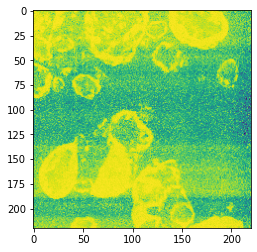

In [13]:
plt.imshow(output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,2]);

In [7]:
criterion = nn.CrossEntropyLoss()
loss = criterion(output, mask.squeeze(1))

In [8]:
loss.item()

0.960009753704071

In [4]:
display_metric_list(accs, 'Accuracy')
display_metric_list(ious, 'IoU')

Mean water Accuracy: 0.9698732495307922
Mean anchor Accuracy: 0.3933025002479553
Mean frazil Accuracy: 0.8551602363586426
Mean water IoU: 0.8888188600540161
Mean anchor IoU: 0.3112097680568695
Mean frazil IoU: 0.6398369073867798


In [5]:
print(np.mean(losses))

0.3716910660266876


In [5]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

197090


In [5]:
params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        params += param.numel()
print(params)

2360


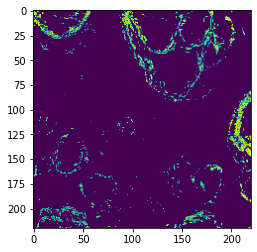

In [15]:
plt.imshow(output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,1]);

In [22]:
batch = test_set[5]
img = batch['image'].unsqueeze(0).to(device=device)
mask = batch['mask'].unsqueeze(0).to(device=device, dtype=torch.long)
prop = batch['prop'].unsqueeze(0).to(device=device, dtype=torch.long)

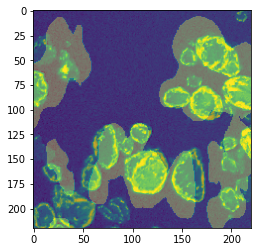

In [23]:
plt.figure()
plt.imshow(img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);
plt.imshow(prop.squeeze(0).squeeze(0).detach().cpu().numpy(), alpha=0.3);

In [13]:
output[0].shape

torch.Size([3, 220, 220])

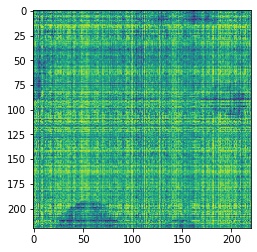

In [10]:
plt.imshow(output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);

In [3]:
img = test_set[1]['image'].unsqueeze(0).to(device=device)
mask = test_set[1]['mask'].unsqueeze(0).to(device=device, dtype=torch.float32)
print(img.shape, mask.shape)

torch.Size([1, 3, 220, 220]) torch.Size([1, 1, 220, 220])


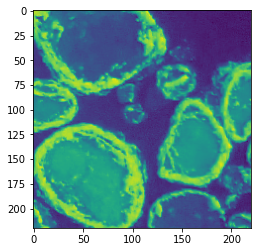

In [4]:
plt.imshow(img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);

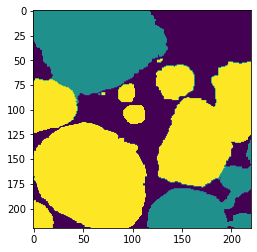

In [5]:
plt.imshow(mask.squeeze(0).squeeze(0).detach().cpu().numpy());

In [6]:
model = BasicAxial(3, 3, 10, img_crop=img_crop).to(device=device)
model.load_state_dict(torch.load('../checkpoints/epoch20.pth', map_location=device))
model.eval()
output = model(img)

/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


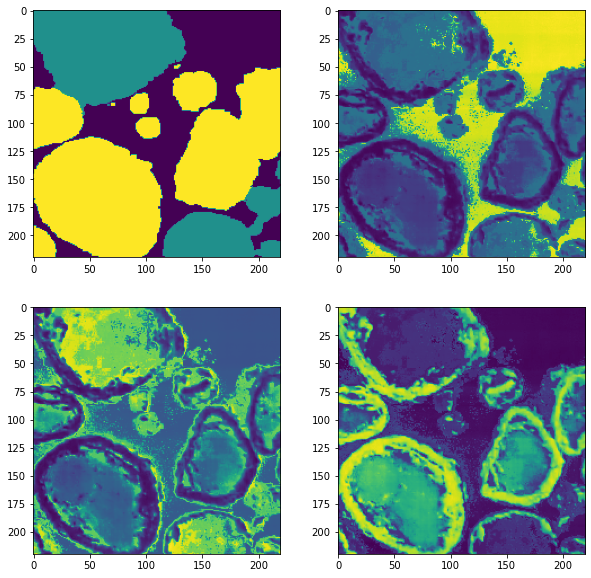

In [7]:
water = output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]
ice1 = output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,1]
ice2 = output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,2]

fix, axs = plt.subplots(2,2, figsize=(10,10))
axs[0][0].imshow(mask.squeeze(0).squeeze(0).detach().cpu().numpy())
axs[0][1].imshow((water))
axs[1][0].imshow((ice1))
axs[1][1].imshow((ice2))

torch.Size([1, 220, 220])


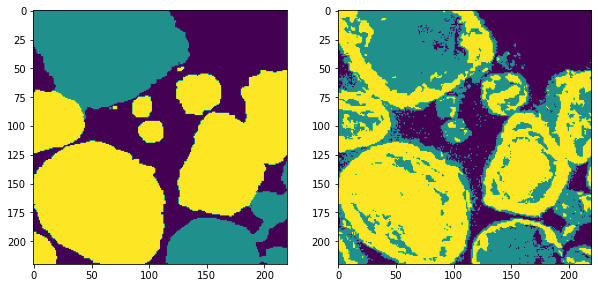

In [12]:
argmx = torch.argmax(output, dim=1)
print(argmx.shape)
fig, axs = plt.subplots(1,2, figsize=(10,10));
axs[0].imshow(mask.squeeze(0).squeeze(0).detach().cpu().numpy());
axs[1].imshow(argmx.squeeze(0).detach().cpu().numpy());

In [13]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

22200


In [23]:
water = probs.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]
ice1 = probs.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,1]
ice2 = probs.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,2]

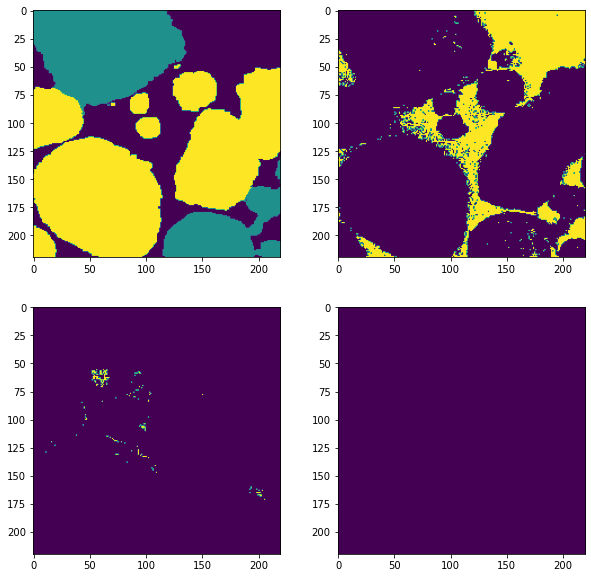

In [27]:
fix, axs = plt.subplots(2,2, figsize=(10,10))
axs[0][0].imshow(mask.squeeze(0).squeeze(0).detach().cpu().numpy())
axs[0][1].imshow((water>0.5))
axs[1][0].imshow((ice1>0.5))
axs[1][1].imshow((ice2>0.5))

In [16]:
np.unique(ice2)

array([6.1915780e-05, 8.1588587e-05, 8.1999642e-05, ..., 4.4421831e-01,
       4.4426095e-01, 4.4441947e-01], dtype=float32)